# Effortless models deployment with Mlflow: Customizing how inference is run

In the previous example, I showed how, by adopting MLFlow for logging models in your experiments, you can gain free deployment options in a variety of targets. However, one of the limitation presented with that is that you have to get along with the default way inference is proposed for the model flavor you are using.

For instance, if you are using fastai, then models will return the probabilities returned by the model directly. But what about if you have to do something different with that outputs? What about if you have to do some preprocessing before submiting the data to the model? In this example, I will show how can log the model using the `pyfunc` flavor to customize how inference is run. Particularly, we will change the output values for the model to return 2 columns: `class`, meaning the class index number (0 or 1), and `label`, meaning the label associated with the given class index.

## The problem: Cats vs Dogs

In this problem, we have to write an algorithm to classify whether images contain either a dog or a cat. This is easy for humans, dogs, and cats, but your computer will find it a bit more difficult.

<img src='https://storage.googleapis.com/kaggle-competitions/kaggle/3362/media/woof_meow.jpg' />

#### The Asirra data set
Web services are often protected with a challenge that's supposed to be easy for people to solve, but difficult for computers. Such a challenge is often called a CAPTCHA (Completely Automated Public Turing test to tell Computers and Humans Apart) or HIP (Human Interactive Proof). HIPs are used for many purposes, such as to reduce email and blog spam and prevent brute-force attacks on web site passwords.

Asirra (Animal Species Image Recognition for Restricting Access) is a HIP that works by asking users to identify photographs of cats and dogs. This task is difficult for computers, but studies have shown that people can accomplish it quickly and accurately. Many even think it's fun! Here is an example of the Asirra interface:

Asirra is unique because of its partnership with Petfinder.com, the world's largest site devoted to finding homes for homeless pets. They've provided Microsoft Research with over three million images of cats and dogs, manually classified by people at thousands of animal shelters across the United States. Kaggle is fortunate to offer a subset of this data for fun and research. 
        

### Solving the problem

Let's start by getting some undestanding of the problem. This is what we know:

<ul>
    <li><b>Problem type:</b> Classification</li>
    <li><b>Number of classes:</b> 2 (cats, dogs)</li>
    <li><b>Input:</b> Images (25.000 — 50% cats, 50% dogs)</li>
</ul>

The dataset is completely balanced. 

## Introducing fast.ai

We are introducing here a framework called fast.ai (https://www.fast.ai/), a framework based on PyTorch with some handy operations already implemented to speed up problem solving quickly. To use fast.ai, we need to import 2 libraries: fastai and torch. fast.ai also has the named dataset already uploaded as part of the framework, which makes pretty convenient to work with it.

> Since fast.ai is a pretty unstable API (it changes very frequently), ensure you version is `fastai==2.4.1`. The `PyTorch` version I'm using is `torch==1.10`

Let's install all the requirements for this notebook:

In [ ]:
%pip install -r fastai-dogs-and-cats.txt --quiet

Importing some libraries

In [1]:
import torch
import fastai
import numpy as np
import pandas as pd

Since this is a computer vision problem, let's load some of the specific classes in FastAI for Computer Vision

In [2]:
from fastai.vision.all import *
from fastai.vision.data import ImageDataLoaders

## Getting started

First things first, let's download and unzip the dataset. Please take into consideration that this dataset is a bit big.

In [3]:
path = untar_data(URLs.DOGS, dest="/tmp/.fastai")
image_files = get_image_files(path)
print('Data located at:', path)

Data located at: /tmp/.fastai/dogscats


As images are unzipped in a folder, we need to create a dataset to use for training and testing. `fast.ai` has a very simple way to do that. The method `ImageDataLoader.from_folder` creates a dataset of images located in a folder. THe folder itself has a pretty peculiar structure (imagenet format) where the data is already divided in trian/test and labels are inferred from the folder containing the image (folder cats contain `cats` and folder dogs contains `dogs`.

`batch_tfms` indicates which image transformations to apply in batches to all the images, while `item_tfms` indicate which transformations will be applied individually to each image. This is useful to construct transformation pipelines right into the data loader. The ds_tfms() method quickly gets a set of random transforms that have proved to work well in a wide range of tasks in computer vision, including a random flip is applied with probability 0.5, a random rotation, a random zoom, a random lightning and contrast change and a random symmetric warp.

Finally, the function normalize creates a normalize/denormalize func using an specific mean and std. In this case, those parameters are taken from the imagenet dataset, using the values imagenet_stats which are means = [0.485, 0.456, 0.406] and stds = [0.229, 0.224, 0.225].

In [4]:
data_loader = ImageDataLoaders.from_folder(path, item_tfms=Resize(224), batch_tfms=Normalize.from_stats(*imagenet_stats))

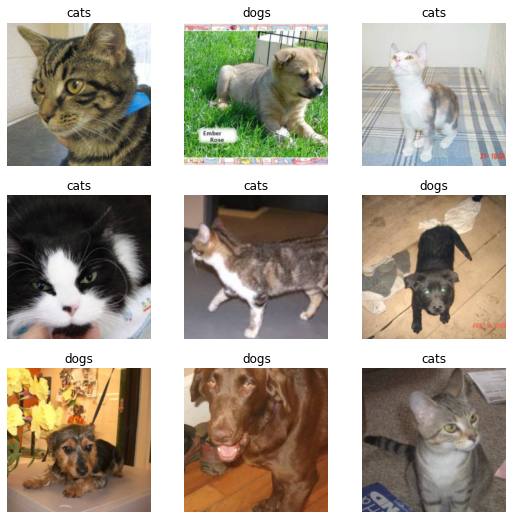

In [5]:
data_loader.train.show_batch()

### Creating a classifier based on ResNet34

#### Starting the mlflow experiment

Before starting, let's create a new experiemnt in Mlflow so we can track all the experimentation on it using Mlflow Tracking.

In [6]:
import mlflow

experiment_id = mlflow.set_experiment("mlflow-cats-vs-dogs")

Let's start the run

In [7]:
mlflow.start_run()

<ActiveRun: >

> **Note:** In general, we would run the training code in a `with` block using `with mlflow.start_run()`. This will ensure that everything in the with block is part of the run and hence mlflow will be able to track the time it takes to run the experiment. Since we are running this interactively in a notebook, we have to run the `start_run()` method at the beginning and `end_run()` at the end.

#### Designing a CNN
Once our dataset is ready, it's time to create our neural network. CNN represents a very convenient way to solve Computer Vision problems, specially when combined with transfer learning. We use transfer learning with a pretrained image classification models to extract visual features. The idea behind it is that the representations learned for task A (typically a high-level task) are applied to task B (typically a lower-level task) as for the degree of success at task B indicates how much the task A model has learned about task B.

In [8]:
learn = cnn_learner(data_loader, models.resnet34, metrics=accuracy)

Then it's time to train. When using transfer learning, the training process is a bit different like in a normal network. In the processes we take a pre-trained model and “fine-tuning” the model with your our own dataset. The idea is that this pre-trained model will act as a feature extractor. You will remove the last layer of the network and replace it with your own classifier. You then freeze the weights of all the other layers and train the network normally

/anaconda/envs/fastai/lib/python3.8/site-packages/fastai/callback/schedule.py:270: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.
  ax.plot(val, idx, 'ro', label=nm, c=color)


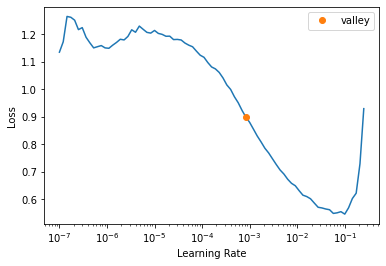

In [10]:
suggested_lr = learn.lr_find()

I'm using here the method `learn.lr_find()`. What this method does behind the scenes is running for few epochs to find out a good learning rate, where it trains from some low learning rate and increase the learning rate after each mini-batch till the loss value starts to explode. This single run provides valuable information on how well the network can be trained over a range of learning rates and what is the maximum learning rate. This is based on a paper https://arxiv.org/abs/1506.01186 which is a really good reading by the way. In Cyclical learning rates (CLR) one specifies minimum and maximum learning rate boundaries and a stepsize. The stepsize is the number of iterations (or epochs) used for each step and a cycle consists of two such steps – one in which the learning rate linearly increases from the minimum to the maximum and the other in which it linearly decreases.

We can then see which is the suggested learning rate by using the property `valley`. Let's use that to train our model.

In [11]:
learn.fine_tune(1, suggested_lr.valley)

epoch,train_loss,valid_loss,accuracy,time
0,0.098955,0.040605,0.985500,42:36


epoch,train_loss,valid_loss,accuracy,time
0,0.047642,0.025463,0.990500,1:10:08


> For simplicity, I'm only training for 1 epoch

### Testing the trained model

Let's see if the model works with an image

In [12]:
from fastai.vision.core import load_image

sample_img = load_image(image_files[1])
sample_img_arr = np.array(sample_img)

> Resizing the image is not required, as the model can do that in its trainsformation's pipeline. The reason why I do this is a bit bellow.

Running the model:

In [13]:
dl_model = learn.dls.test_dl([sample_img_arr])
real_preds, _ = learn.get_preds(dl=dl_model)

In [14]:
print(real_preds)

tensor([[1.0000e+00, 8.7753e-10]])


To obtain the class rather than the probabily, we can do something like this:

In [15]:
class_idxs = real_preds.argmax(axis=1)
print(class_idxs)

tensor([0])


In [16]:
res = [(c.numpy(), learn.dls.vocab[c]) for c in class_idxs]
print(res)

[(array(0), 'cats')]


### Persisting the model

Once the model is trained, it's time to save the work. 

> **Note:** An important distinction here, `learn.save` will save the model itself in the `PyTorch` format, while the method `learn.export` will save both the model along with all the data transformations applied. This is important since at inference time our model expects to recive images that has been altered the same way the previous data loaded did.

In [17]:
saved_model = "/tmp/.fastai/dogscats/model.fastai"
learn.export(saved_model)

#### Creating the signature

The model will take batches of images and will return the class probabilities of each class (in our case either cat or dog). This means that our inputs will be tensors of shape `(IMAGE_HEIGHT, IMAGE_WIDTH, CHANNELS)`. Since the model expects batches of images, the right input shape is `(BATCH_SIZE, IMAGE_HEIGHT, IMAGE_WIDTH, CHANNELS)`.

For our output, we want to return both the class index and the class label. Then, our output signature will have a shapre `(-1, 2)` but with an specific struncture: two columns: `class` and `label`.

The schema then will be as follows:

In [18]:
import numpy as np
from mlflow.models.signature import ModelSignature
from mlflow.types.schema import Schema, TensorSpec, ColSpec
from mlflow.types import DataType

input_schema = Schema([
  TensorSpec(np.dtype(np.uint8), (-1, -1, -1, 3)),
])
output_schema = Schema([
  ColSpec(DataType.integer, "class"),
  ColSpec(DataType.string, "label"),
])
signature = ModelSignature(inputs=input_schema, outputs=output_schema)

Some notes:

- **input_schema**: Our model can handle variable image sizes, since it has a transformation that resizes the image in the process (the `Resize(224)` transformation). Then, we can indicate a variable input size using -1 in `height` and `width`. The same applies to batch size, since we can handle variable sizes.

- **output_schema**: Our model will return two columns. We are not using tensor specification cause we want to be explicit about what are the things we are returning, so we can see we are actually indicating which is the name of the columns we return.

#### Saving the model in the Mlflow format

To save the model using Mlflow, we can call the function `mlflow.fastai.log_model`. However, this function will run the model and return its output directly, without any further processing. We can change this behaviour by using the `pyfunc` flavor:

We can use the pyfunc flavor in two ways:

- The simplest way is to provide a custom model loader module.
- Create a custom flavor. This one is a bit more complex.

**In this example we will use the first one**. To use `pyfunc` flavor with a custom model loader, we are asked to implement two things:

- a class that acts as a model wrapper. This class has to have a method `predict()`.
- a model loader function called `_load_pyfunc(path)` where path is the path to the models' artifact and that returns an instance of the previosly mentioned class.

Let's have a lookg at how we can achieve this:

First let's create the model class:

In [19]:
class _FastaiClassifierModelWrapper:
    def __init__(self, learner):
        self.learner = learner

    def predict(self, data):
        import pandas as pd
        import numpy as np
        
        dl = self.learner.dls.test_dl(data)
        preds, _ = self.learner.get_preds(dl=dl)
        
        # converting probabilities to classes
        class_idxs = preds.argmax(axis=1)
        results = [(c.numpy(), self.learner.dls.vocab[c]) for c in class_idxs]
        
        return pd.DataFrame(results, columns=["class", "label"])

This simple class contains:

- A constructor that recieves an instance of a `fastai.learner` model.
- The predict function we are required to implement. This function recieves a data an returns the predictions in a datafrae with a columns named `predictions`. 

Finally, we need to provide a way to load this model. Again, this is done by implementing the function `_load_pyfunc()`:

In [20]:
def _load_pyfunc(path):
    import os
    from fastai.learner import load_learner
    
    learn = load_learner(os.path.abspath(path))
    
    return _FastaiModelWrapperPatch(learn)

That's all! Now let's place this inside of a module so we can use it later:

In [21]:
%%writefile fastai_classifier_module.py

class _FastaiClassifierModelWrapper:
    def __init__(self, learner):
        self.learner = learner

    def predict(self, data):
        import pandas as pd
        import numpy as np
        
        dl = self.learner.dls.test_dl(data)
        preds, _ = self.learner.get_preds(dl=dl)
        
        # converting probabilities to classes
        class_idxs = preds.argmax(axis=1)
        results = [(c.numpy(), self.learner.dls.vocab[c]) for c in class_idxs]
        
        return pd.DataFrame(results, columns=["class", "label"])

def _load_pyfunc(path):
    import os
    from fastai.learner import load_learner
    
    learn = load_learner(os.path.abspath(path))
    
    return _FastaiClassifierModelWrapper(learn)

Overwriting fastai_classifier_module.py


Now it's time to log the model in MLFlow:

In [22]:
model_info = mlflow.pyfunc.log_model("classifier", 
                                    data_path=saved_model, 
                                    code_path=["./fastai_classifier_module.py"], 
                                    loader_module="fastai_classifier_module", 
                                    registered_model_name="cats_vs_dogs", 
                                    signature=signature)

Registered model 'cats_vs_dogs' already exists. Creating a new version of this model...
2022/03/16 16:41:40 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation.                     Model name: cats_vs_dogs, version 24
Created version '24' of model 'cats_vs_dogs'.


Let's unpack how this instruction works:

- **classifier** is the artifacts path we will use. Same as before, we are using the path `classifier`.
- **data_path** is the model artifact. When we used `mlflow.fastai.log_model`, MLFlow automatically saved our model to disk to then include it inside the MLModel package. However, when we use `pyfunc`, this doesn't happen automatically. We have full controll of it so we have to persist the model to disk. We did that before, and we saved the path where the model was persisted in a variable called `saved_model`. 
- **code_path** is where the code for the `pyfunc` logic is located. We placed all the logic inside of the file `fastai_classifier_module.py`. So we pass that file path.
- **loader_module** is the name of the module where the `_load_pyfunc` function is defined. In our case, that function is inside the file `fastai_classifier_module.py`. Remmeber that in Python, files are modules and the name of the associated module is the name of the file, so the name of the module here is `fastai_classifier_module`. If you are thinking "this looks redundant", it worth to mention that code_path can be the path to a directory, containing multiple code files. MLFLow will snapshop all the files in that directory, so it needs to know which of all those files (in our case is just one) is the one it has to load first.

### Ending the experiment

Since we were running this experiment interactively in this notebook, we have to end it using:

In [23]:
mlflow.end_run()

## Deploying your model using mlflow

Now, let's see how we can deploy the model using Mlflow. Before doing that, it is always good to check that our model was persisted correctly and that it can be loaded. This will save us some time later in case something wrong happens.

Let's grab the URI of the model we just registered. 

In [24]:
serving_model_uri = model_info.model_uri
print(serving_model_uri)

runs:/687e5014-7644-4029-8af5-7d9b9b1c170e/classifier


That's the URI of the model inside the run (which we can totally deploy if we want to). However, I'm interested in deployed the model that ended registered in the Registry. This model will have a URI with the form `models:/cats_vs_dogs/1`.

In [25]:
serving_model_uri = 'models:/cats_vs_dogs/1'

### Loading the model just logged in MLFLow using the pyfunc flavor.

First, let's try to load the model using the `pyfunc` flavor into this notebook. We can use this method to check that the model can be loaded correctly.

In [26]:
mlflow_model = mlflow.pyfunc.load_model(serving_model_uri)

Let's create a simple batch to test it out:

In [27]:
sample_batch = sample_img_arr.reshape(1, sample_img.height, sample_img.width,3)

In [28]:
mlflow_model.predict(sample_batch)

,class,label
0,0,cats


> Note how we use here the method `predict` to run the predictions, but now we get classes instead of probabilities. Compare this with the way we used to run the model before in the section [Testing the trained model](#Testing-the-trained-model)

### Running the model in a local server

We can run the model in an inference server locally in our local compute. Again, with this we can check that our deployment strategy will work. 

To do so, let's serve our model using mlflow:

```bash
mlflow models serve -m models:/cats_vs_dogs/1
```

Creating a sample request

In [29]:
import json

with open("sample.json", "w") as f:
    f.write(json.dumps(
        {
            "instances": sample_batch.tolist()
        }
    ))

Sending the request

In [30]:
!cat -A sample.json | curl http://127.0.0.1:5000/invocations \
                        --request POST \
                        --header 'Content-Type: application/json' \
                        --data-binary @-

[{"class": "0", "label": "cats"}]

## Deploying the model to Azure ML

MLflow is integrated with several Machine Learning platforms, including Azure ML. We can deploy models created with MLFlow without changing any single implementation about them. They can be deployed to Azure Container Instances - ACI, Azure Kubernetes - AKS, or to Managed Endpoints - MIR.

To perform this operation, you have to have the plugin `azureml-mlflow` installed:

In [ ]:
%pip install azureml-mlflow==1.39.0

In [ ]:
import json
import mlflow
from mlflow.deployments import get_deploy_client

Create the deployment configuration. If no deployment configuration is provided, then the deployment happens on ACI.

In [ ]:
deploy_config = {
    "computeType": "aci",
    "containerResourceRequirements":
    {
        "cpu": 2,
        "memoryInGB": 4
    }
}

Write the deployment configuration into a file.

In [ ]:
deployment_config_path = "deployment_config.json"
with open(deployment_config_path, "w") as outfile:
    outfile.write(json.dumps(deploy_config))

Set the tracking uri as the deployment client. If you are running inside a Compute Instance in Azure ML, then you can use `mlflow.get_tracking_uri()`.

In [ ]:
client = get_deploy_client(mlflow.get_tracking_uri())

> If you are running outside an Azure ML compute, then you need to get the tracking URL of the workspace you are working on. To do so go to https://ml.azure.com, then click on the name of your workspace in the uper right corner, and click on View all properties in Azure Portal. There, copy the value of the property `MLflow tracking URI` and place it as paramter of `get_deploy_client` like this:

```python
client = get_deploy_client('azureml://eastus.api.azureml.ms/mlflow/v1.0/subscriptions/<GUID>/resourceGroups/<RESOURCE_GROUP>/providers/Microsoft.MachineLearningServices/workspaces/<WORKSPACE_NAME>')
```

MLflow requires the deployment configuration to be passed as a dictionary.

In [ ]:
config = {'deploy-config-file': deployment_config_path}
model_name = "cats_vs_dogs"
model_version = 1

Define the model path and the name is the service name. If model is not registered, it gets registered automatically and a name is autogenerated using the "name" parameter below

In [ ]:
client.create_deployment(model_uri=f'models:/{model_name}/{model_version}',
                        config=config,
                        name="cats-vs-dogs-aci-deployment")

After the model deployment completes, requests can be posted via HTTP to the new ACI webservice's scoring URI.

In [ ]:
print("Scoring URI is: %s", webservice.scoring_uri)